In [1]:
%load_ext autoreload
%autoreload 2
import warnings

warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import torch

from PycalcAct.dataset import Dataset
from PycalcAct.model import (
    MixedFCTemporalModel,
)
from PycalcAct.trainer import Trainer

_ = torch.manual_seed(1234)


In [10]:
dataset = Dataset(
    csv_path=["../data/legend.csv", "../data/calciumBound.csv", "../data/calciumFree.csv"],
    csv_pos_path="/home/clement/Documents/Sebastien/dataMcGill/position.csv",  # Optional
    position_to_displacement=True,
    # Convert the x, y position to a single displacement value (sqrt((x(t+1)-x(t))^2 + (y(t+1)-y(t))^2)
)


def caBound_over_caFree(x):
    return x[:, 0] / (x[:, 1] + 1e-7)


def caFree_over_caBound(x):
    return x[:, 1] / (x[:, 0] + 1e-7)


dataset.create_new_feature_by_operations(caBound_over_caFree)
dataset.create_new_feature_by_operations(caFree_over_caBound)

dataset.drop_features_by_name("calciumBound", "calciumFree")

# dataset.create_new_feature_by_operations(lambda x: np.abs(np.fft.fft(x[:, 1])))
# dataset.create_new_feature_by_operations(lambda x: np.abs(np.fft.fft(x[:, 0])))

model = MixedFCTemporalModel(
    n_classes=dataset.n_classes,
    rnn_hidden_size=128,
    n_rnn_layers=1,
    fc_hidden_size=64,
    temporal_length=dataset.length_serie,
    input_size=dataset.features,
    bidirectional=False,
    pooling=None,
)

n_epochs = 750
trainer = Trainer(
    dataset,
    model,
    device="cuda",
    batch_size=4096,
    weight_decay=1e-3,
)  # You can pass your own optimizer, criterion, learning rate, weight decay and learning rate scheduler.


In [11]:
trainer.summary(optimizer=False, model=True, data=True)

Model
Layer (type:depth-idx)                   Output Shape              Param #
MixedFCTemporalModel                     [10, 4]                   --
├─GRU: 1-1                               [10, 120, 128]            51,072
├─Sequential: 1-2                        [10, 64]                  --
│    └─Sequential: 2-1                   [10, 64]                  --
│    │    └─Linear: 3-1                  [10, 64]                  983,104
│    │    └─ReLU: 3-2                    [10, 64]                  --
│    │    └─Dropout1d: 3-3               [10, 64]                  --
│    └─Sequential: 2-2                   [10, 64]                  --
│    │    └─Linear: 3-4                  [10, 64]                  4,160
│    │    └─ReLU: 3-5                    [10, 64]                  --
│    │    └─Dropout1d: 3-6               [10, 64]                  --
├─Linear: 1-3                            [10, 4]                   260
Total params: 1,038,596
Trainable params: 1,038,596
Non-trainable 

,Total,N4,Q4,Q4H7,T4
Train,16084,6144,4790,2299,2851
Validation,4022,1536,1198,575,713
Test,5027,1920,1497,719,891
Total,25133,9600,7485,3593,4455


# Learning with Displacement encoding

╭───────────────────────────┬───────────────────────────┬───────────────────────────╮
│           Epoch           │                      Loss │                  Accuracy │
├───────────────────────────┼───────────────────────────┼───────────────────────────┤
│             0             │                      1.99 │                     18.35 │
│             1             │                      1.47 │                     40.33 │
│             3             │                      1.33 │                     45.65 │
│             5             │                      1.31 │                     45.92 │
│             7             │                      1.29 │                     46.82 │
│             8             │                      1.28 │                     47.69 │
│             9             │                      1.27 │                     47.71 │
│             10            │                      1.27 │                     48.68 │
│             12            │                      1.2

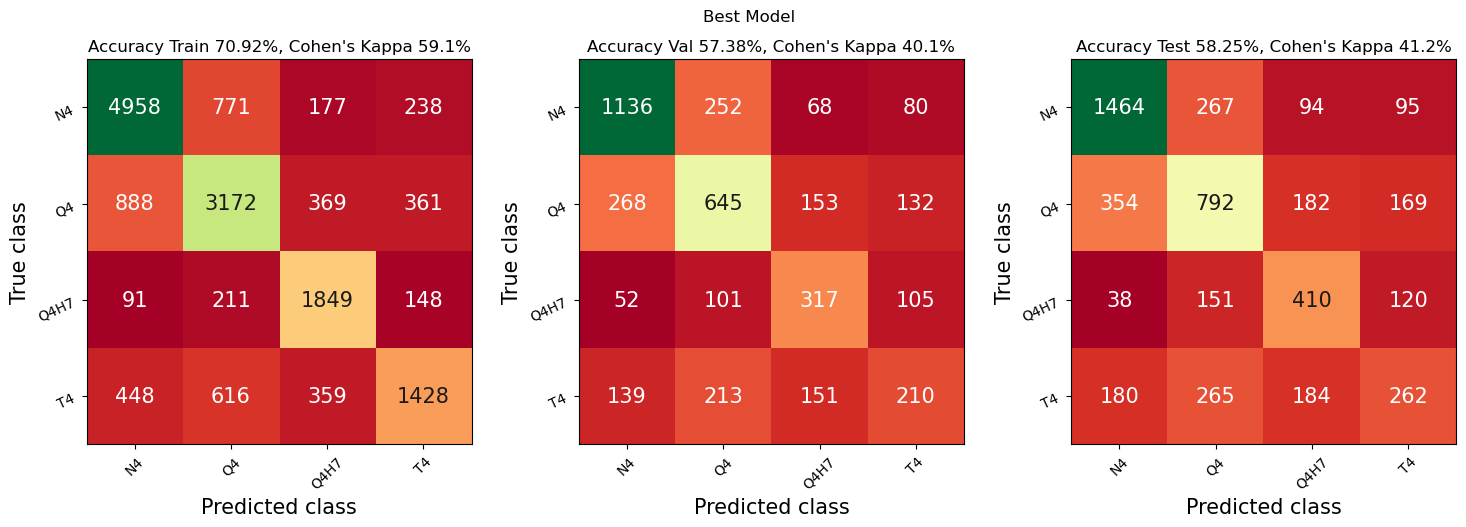

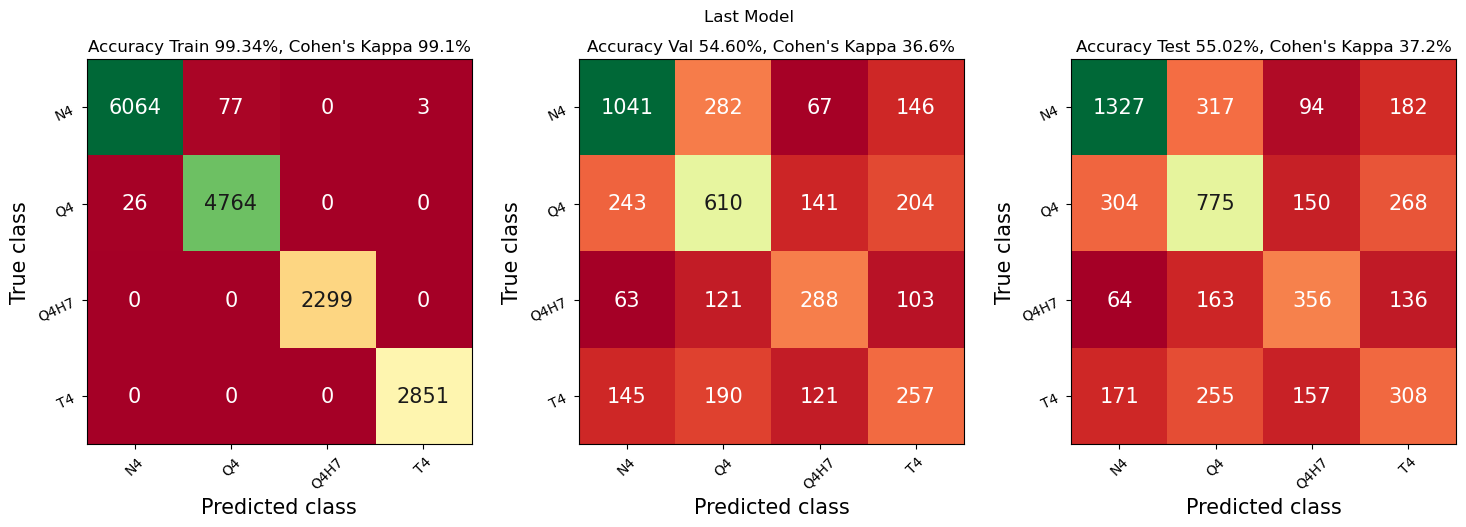

In [5]:
trainer.train(n_epochs)
trainer.test("best")  # Testing on the best model (in term of validation accuracy)
trainer.test("last")  # Testing on the last model

# Learning without displacement encoding

╭───────────────────────────┬───────────────────────────┬───────────────────────────╮
│           Epoch           │                      Loss │                  Accuracy │
├───────────────────────────┼───────────────────────────┼───────────────────────────┤
│             0             │                      1.37 │                     39.38 │
│             1             │                      1.34 │                     40.97 │
│             2             │                      1.34 │                     43.41 │
│             3             │                      1.32 │                     46.00 │
│             10            │                      1.27 │                     46.15 │
│             11            │                      1.26 │                     47.79 │
│             19            │                      1.25 │                     49.38 │
│             20            │                      1.24 │                     50.02 │
│             45            │                      1.2

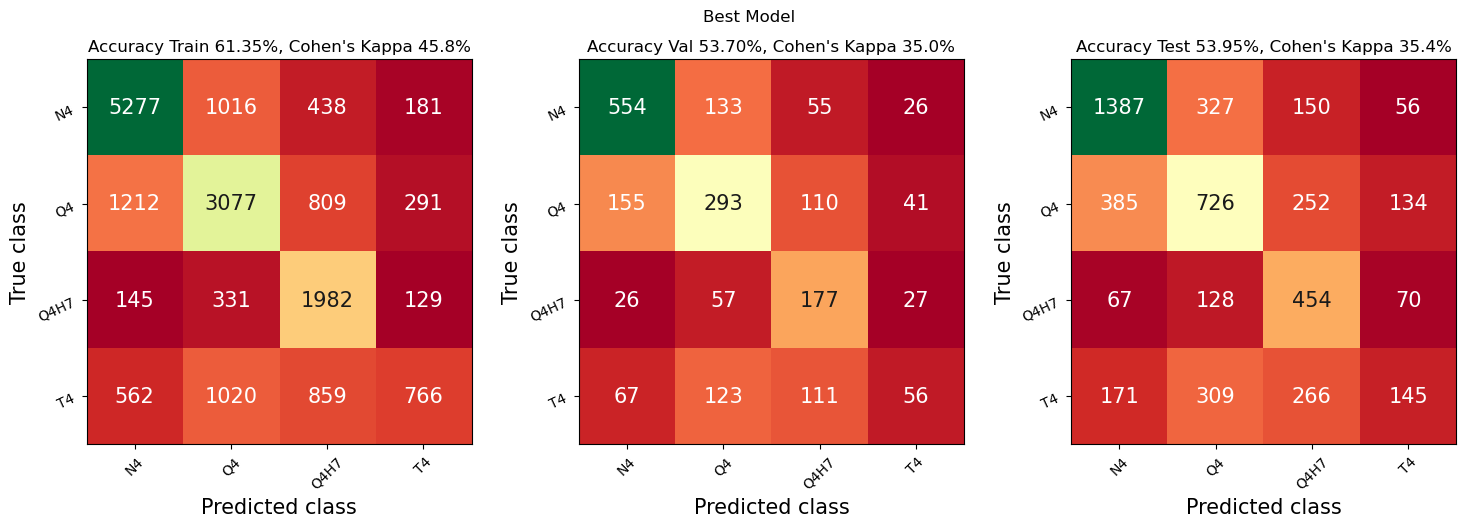

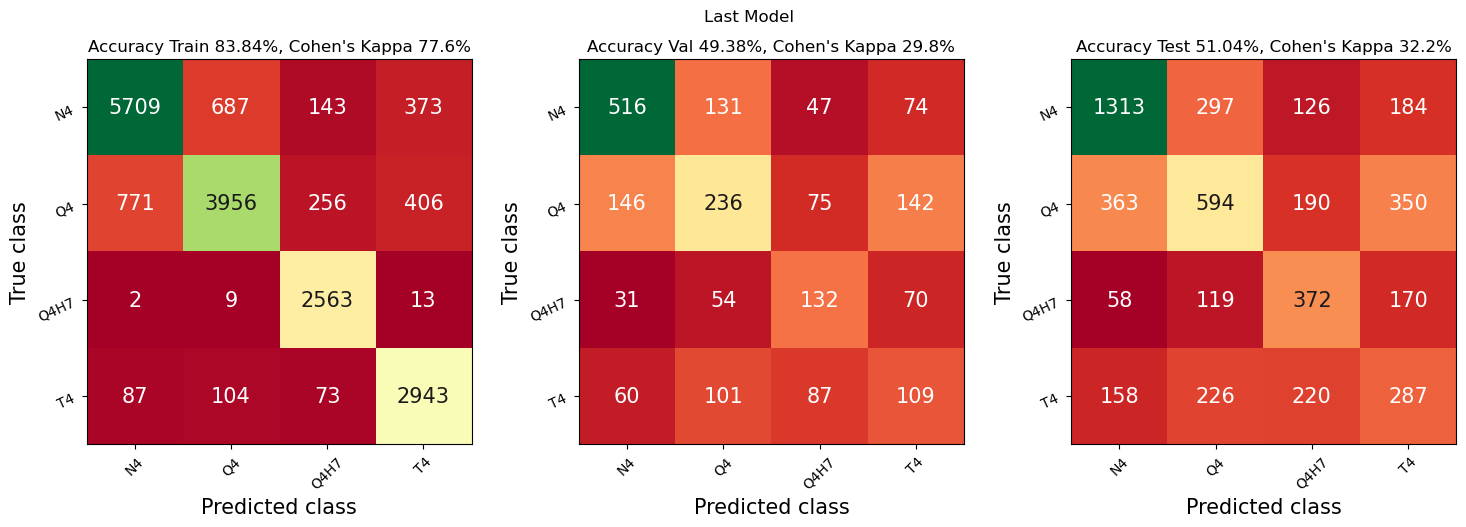

In [6]:
dataset = Dataset(
    csv_path=["../data/legend.csv", "../data/calciumBound.csv", "../data/calciumFree.csv"],
    csv_pos_path=None,
    test_size=0.2,
    val_size=0.1,
)
model = MixedFCTemporalModel(
    n_classes=dataset.n_classes,
    temporal_length=dataset.length_serie,
    input_size=dataset.features,
)
trainer.reset(dataset, model)
trainer.train(n_epochs)
trainer.test("best")  # Testing on the best model (in term of validation accuracy)
trainer.test("last")  # Testing on the last model

# Learning vastly overparametrized model and no regularization

╭───────────────────────────┬───────────────────────────┬───────────────────────────╮
│           Epoch           │                      Loss │                  Accuracy │
├───────────────────────────┼───────────────────────────┼───────────────────────────┤
│             0             │                      1.39 │                     14.30 │
│             1             │                      1.38 │                     31.18 │
│             3             │                      1.36 │                     36.30 │
│             4             │                      1.34 │                     41.00 │
│             6             │                      1.29 │                     41.17 │
│             10            │                      1.29 │                     42.64 │
│             12            │                      1.29 │                     43.01 │
│             13            │                      1.30 │                     43.16 │
│             27            │                      1.2

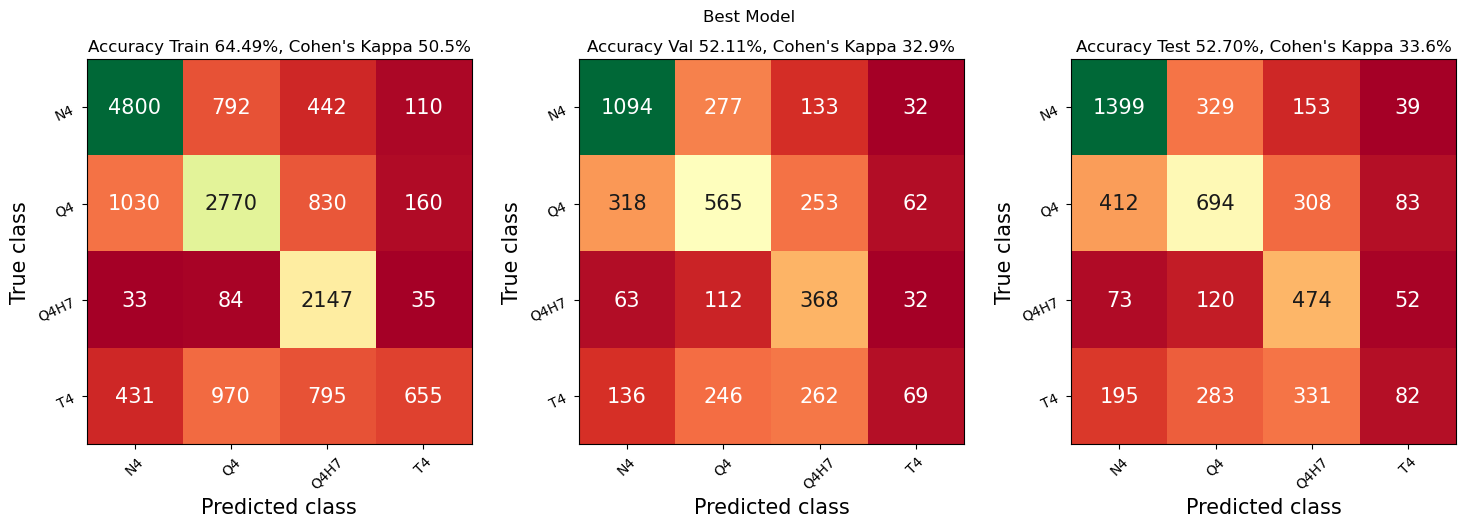

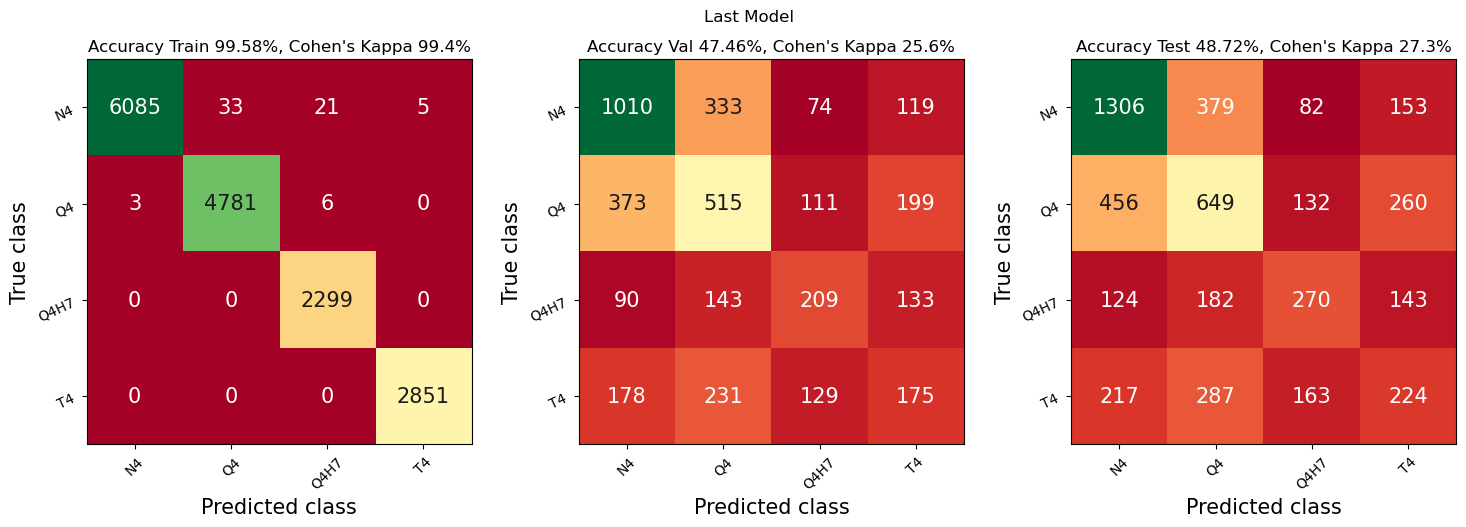

In [74]:
dataset = Dataset(
    csv_path=["../data/legend.csv", "../data/calciumBound.csv", "../data/calciumFree.csv"],
    csv_pos_path="../data/position.csv",
    position_to_displacement=True,
)
model = MixedFCTemporalModel(
    n_fc_layers=4,
    n_rnn_layers=4,
    n_classes=dataset.n_classes,
    temporal_length=dataset.length_serie,
    input_size=dataset.features,
    rnn_hidden_size=32,
    fc_hidden_size=256,
    dropout=0.0,
)
trainer.weight_decay = 0.0
trainer.reset(dataset=dataset, model=model)
trainer.train(n_epochs)

trainer.test("best")  # Testing on the best model (in term of validation accuracy)
trainer.test("last")  # Testing on the last model


# Same model with strong regularization
To regularize, we use dropout (randomly dropping some neurons with a probability p) and weight decay.

╭───────────────────────────┬───────────────────────────┬───────────────────────────╮
│           Epoch           │                      Loss │                  Accuracy │
├───────────────────────────┼───────────────────────────┼───────────────────────────┤
│             0             │                      1.39 │                     14.30 │
│             1             │                      1.39 │                     39.86 │
│             7             │                      1.37 │                     41.32 │
│            749            │                      1.35 │                           │
╰───────────────────────────┴───────────────────────────┴───────────────────────────╯


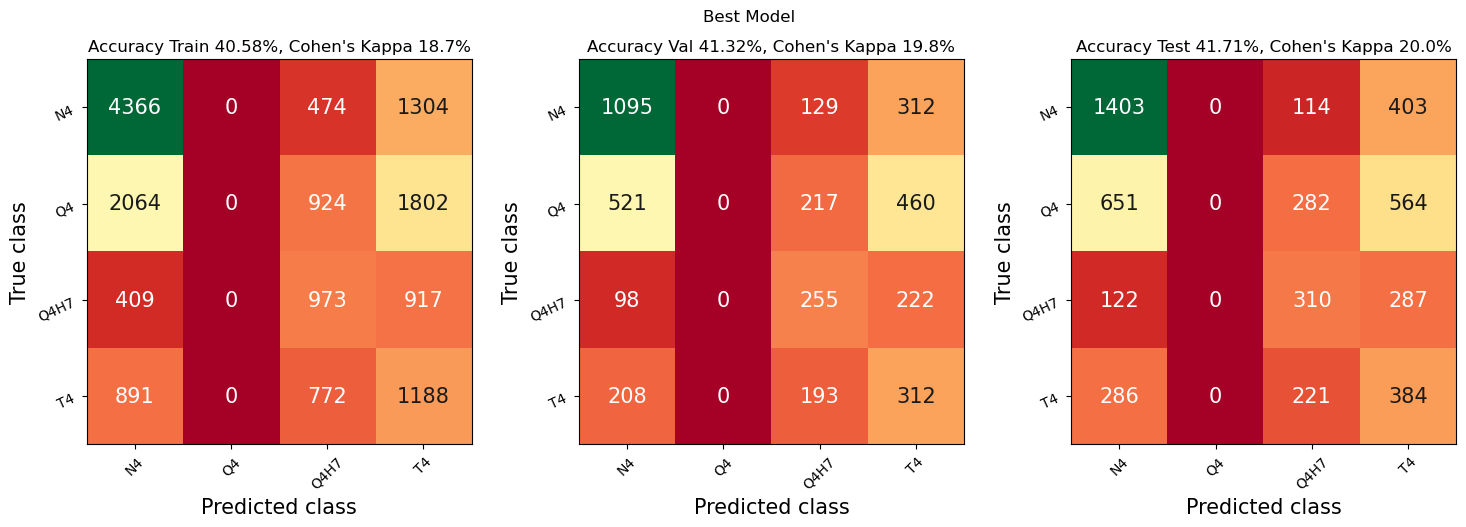

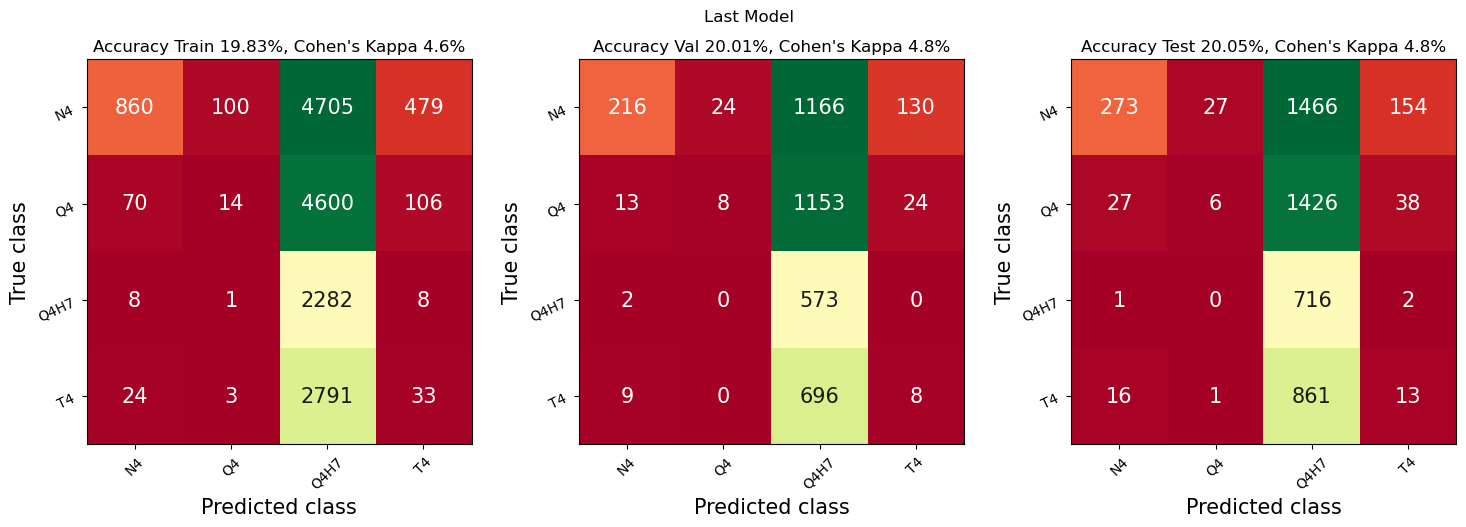

In [75]:
dataset = Dataset(
    csv_path=["../data/legend.csv", "../data/calciumBound.csv", "../data/calciumFree.csv"],
    csv_pos_path="../data/position.csv",
    position_to_displacement=True,
)
model = MixedFCTemporalModel(
    n_fc_layers=4,
    n_rnn_layers=4,
    n_classes=dataset.n_classes,
    temporal_length=dataset.length_serie,
    input_size=dataset.features,
    rnn_hidden_size=32,
    fc_hidden_size=128,
    dropout=0.3,
)
trainer.weight_decay = 0.0005
trainer.reset(dataset=dataset, model=model)
trainer.train(n_epochs)
trainer.test("best")  # Testing on the best model (in term of validation accuracy)
trainer.test("last")  # Testing on the last model


# Tiny model

╭───────────────────────────┬───────────────────────────┬───────────────────────────╮
│           Epoch           │                      Loss │                  Accuracy │
├───────────────────────────┼───────────────────────────┼───────────────────────────┤
│             0             │                      1.44 │                     29.79 │
│             10            │                      1.33 │                     43.11 │
│             70            │                      1.24 │                     43.51 │
│             80            │                      1.23 │                     44.11 │
│             90            │                      1.22 │                     44.28 │
│            100            │                      1.21 │                     44.48 │
│            110            │                      1.20 │                     44.75 │
│            120            │                      1.19 │                     46.00 │
│            130            │                      1.1

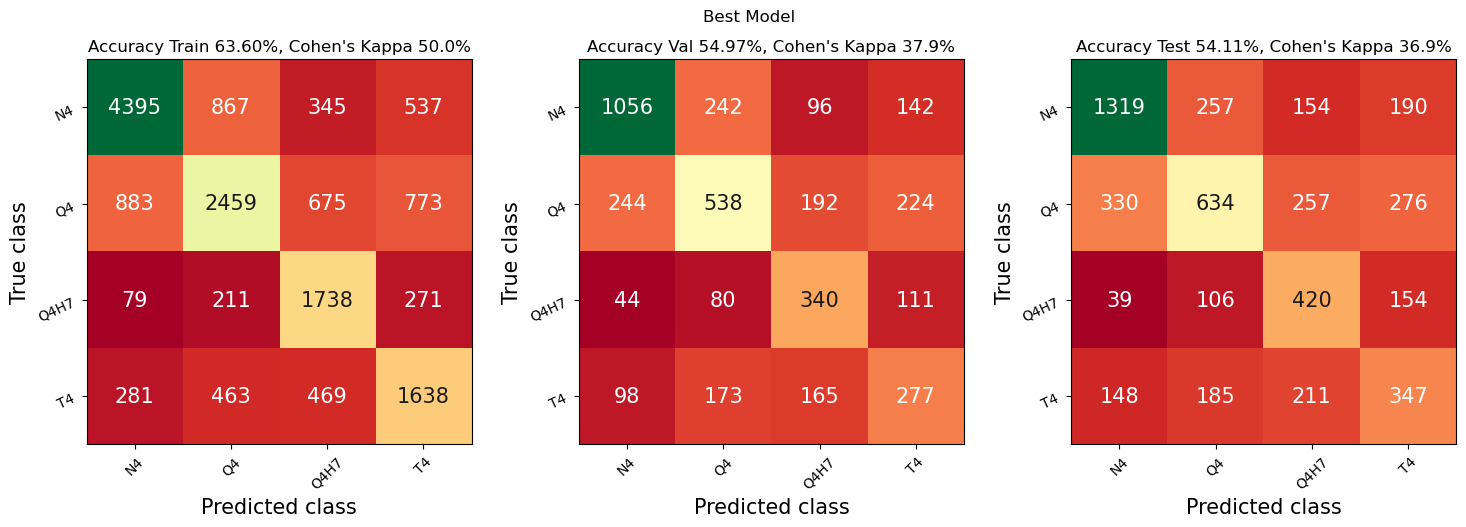

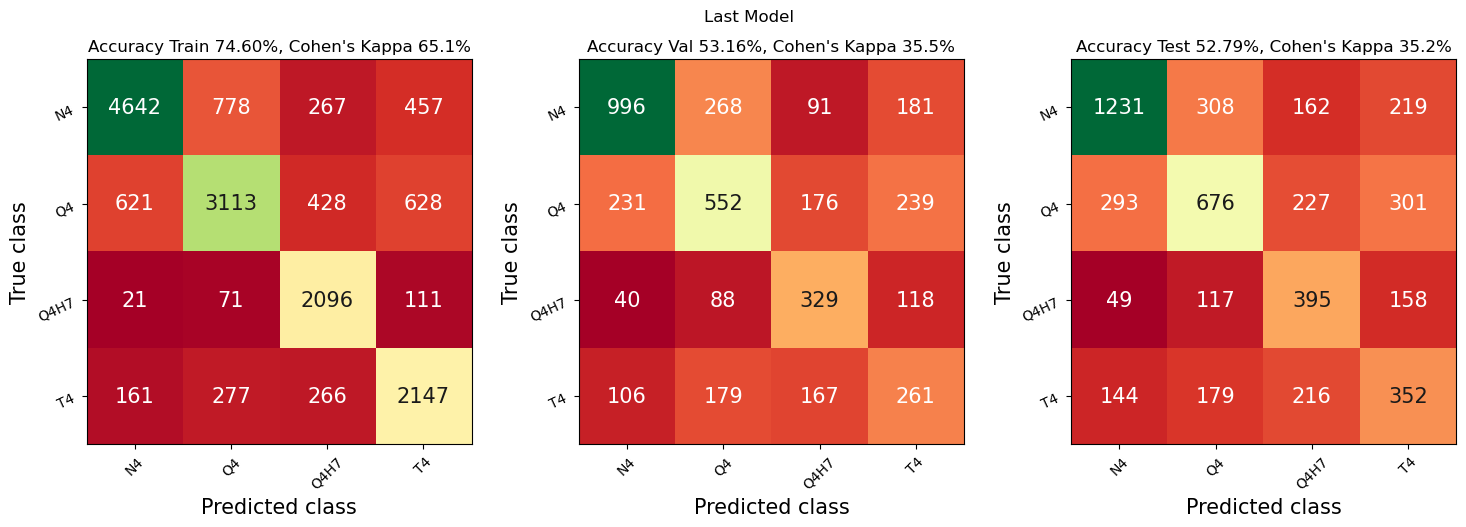

In [76]:
dataset = Dataset(
    csv_path=["../data/legend.csv", "../data/calciumBound.csv", "../data/calciumFree.csv"],
    csv_pos_path="../data/position.csv",
    position_to_displacement=True,
)
model = MixedFCTemporalModel(
    n_fc_layers=1,
    n_rnn_layers=1,
    n_classes=dataset.n_classes,
    temporal_length=dataset.length_serie,
    input_size=dataset.features,
    rnn_hidden_size=16,
    fc_hidden_size=16,
    dropout=0,
    bidirectional=True,
    use_gru=True,
)
n_epochs = 2500  # We train for more epochs as it is a smaller model (thus faster).

trainer.reset(model=model)
trainer.train(n_epochs, val_every=10)
trainer.test("best")  # Testing on the best model (in term of validation accuracy)

trainer.test("last")  # Testing on the last model


In [6]:
trainer.save()

In [10]:
def Sequential(**layers):
    for name, args in layers.items():
        print(name, args)


fcs = [1, 2, 3, 4, 5]
Sequential(a=1, b=2)

a 1
b 2


In [ ]:
trainer.use_class_weights = False
trainer.criterion = torch.nn.CrossEntropyLoss()
